In [1]:
#from models.nalu import NALU
import torch.nn.functional as F
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn')

In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

from models.nac import NeuralAccumulatorCell
from torch.nn.parameter import Parameter


import random
import math
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

from torch.nn.parameter import Parameter


class NeuralAccumulatorCell(nn.Module):
    """A Neural Accumulator (NAC) cell [1].

    Attributes:
        in_dim: size of the input sample.
        out_dim: size of the output sample.

    Sources:
        [1]: https://arxiv.org/abs/1808.00508
    """
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.W = 0

        self.W_hat = Parameter(torch.Tensor(out_dim, in_dim))
        self.M_hat = Parameter(torch.Tensor(out_dim, in_dim))

        self.register_parameter('W_hat', self.W_hat)
        self.register_parameter('M_hat', self.M_hat)
        self.register_parameter('bias', None)

        self._reset_params()

    def _reset_params(self):
        init.kaiming_uniform_(self.W_hat)
        init.kaiming_uniform_(self.M_hat)

    def forward(self, input):
        W = torch.tanh(self.W_hat) * torch.sigmoid(self.M_hat)
        self.W = W
        return F.linear(input, W, self.bias)

    def extra_repr(self):
        return 'in_dim={}, out_dim={}'.format(
            self.in_dim, self.out_dim
        )


class NAC(nn.Module):
    """A stack of NAC layers.

    Attributes:
        num_layers: the number of NAC layers.
        in_dim: the size of the input sample.
        hidden_dim: the size of the hidden layers.
        out_dim: the size of the output.
    """
    def __init__(self, num_layers, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.num_layers = num_layers
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim

        layers = []
        for i in range(num_layers):
            layers.append(
                NeuralAccumulatorCell(
                    hidden_dim if i > 0 else in_dim,
                    hidden_dim if i < num_layers - 1 else out_dim,
                )
            )
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        out = self.model(x)
        return out

    
class NeuralArithmeticLogicUnitCell(nn.Module):
    """A Neural Arithmetic Logic Unit (NALU) cell [1].

    Attributes:
        in_dim: size of the input sample.
        out_dim: size of the output sample.

    Sources:
        [1]: https://arxiv.org/abs/1808.00508
    """
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.eps = 1e-10

        self.G = Parameter(torch.Tensor(out_dim, in_dim))
        self.nac = NeuralAccumulatorCell(in_dim, out_dim)
        self.register_parameter('bias', None)

        init.kaiming_uniform_(self.G, a=math.sqrt(5))

    def forward(self, input):

        a = self.nac(input)
        g = torch.sigmoid(F.linear(input, self.G, self.bias))
        add_sub = g * a
        log_input = torch.log(torch.abs(input) + self.eps)
        m = torch.exp(self.nac(log_input))
        mul_div = (1 - g) * m
        y = add_sub + mul_div
        return y, g, self.nac.W, self.G

    def extra_repr(self):
        return 'in_dim={}, out_dim={}'.format(
            self.in_dim, self.out_dim
        )


class NALU(nn.Module):
    """A stack of NAC layers.

    Attributes:
        num_layers: the number of NAC layers.
        in_dim: the size of the input sample.
        hidden_dim: the size of the hidden layers.
        out_dim: the size of the output.
    """
    
    def __init__(self, num_layers, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.num_layers = num_layers
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.g = []
        self.W = []
        self.G = []

        layers = []
        for i in range(num_layers):
            layers.append(
                NeuralArithmeticLogicUnitCell(
                    hidden_dim if i > 0 else in_dim,
                    hidden_dim if i < num_layers - 1 else out_dim,
                )
            )
        self.model = nn.Sequential(*layers)
        
    def forward(self, x, training):

        out, g , W, G = self.model(x)
        
        if training:
        
            self.W.append(W.data.numpy())
            self.g.append(g)
            self.G.append(G.detach().numpy().copy())
        
        return out

In [3]:
def test(model, data, target):
    with torch.no_grad():
        out = model(data)
        return torch.abs(target - out)

In [4]:
def train(model, optimizer, num_iters, train_support, val_support, input_noise, target_noise):
    training_loss = []
    training_error = []
    val_error = []
    train_data = []
    val_data = []

    for i in range(num_iters):
        
        # Training
        training = True
        x_train, y_train = generate_data(fn, train_support, input_noise, target_noise)
        train_data.append(y_train.detach().numpy().copy())
        
        out = model(x_train, training)

        loss = F.mse_loss(out, y_train)
        training_loss.append(loss.data.numpy())
        
        training_error.append( (y_train - out).detach().numpy().copy() )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Validation
        training = False
        x_val, y_val = generate_data(fn, val_support, input_noise, target_noise)
        val_data.append(y_val.detach().numpy().copy())

        out = model(x_val, training)
        
        val_error.append( (y_val - out).detach().numpy().copy() )


    return training_loss, training_error, val_error, train_data, val_data
            

In [5]:
def generate_data(fn, support, input_noise, target_noise):

    # support = range of distribution
    # num_test = number of points in test set
    dim = 2
    X = torch.FloatTensor(dim).uniform_(*support).unsqueeze_(1)
    
    input_noise = torch.randn(np.shape(X))*input_noise 
    X = X + input_noise
    
    Y = fn(X[0],X[1]).unsqueeze_(1)
    
    target_noise = torch.randn(np.shape(Y))*target_noise
    Y = Y + target_noise
    
    return torch.transpose(X,0,1), Y

In [6]:
in_dim = 2
hidden_dim = 1
out_dim = 1
num_layers = 1

dim = in_dim # dimensition for generating data

net = NALU(num_layers, in_dim, hidden_dim, out_dim)
print(net)

NALU(
  (model): Sequential(
    (0): NeuralArithmeticLogicUnitCell(
      in_dim=2, out_dim=1
      (nac): NeuralAccumulatorCell(in_dim=2, out_dim=1)
    )
  )
)


# Weights (Addition)

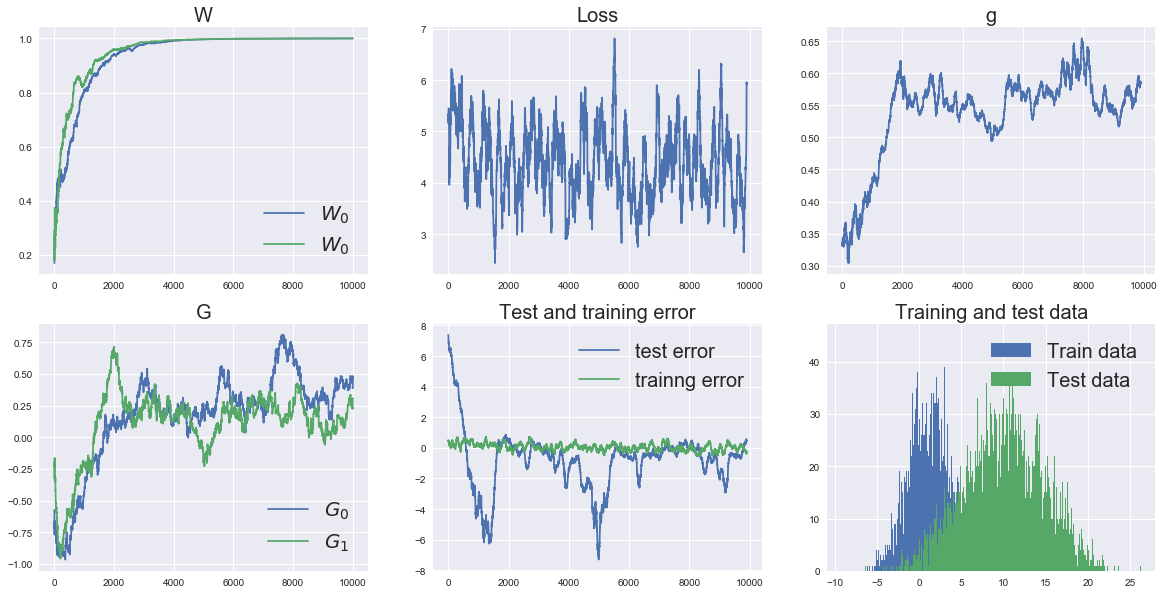

In [13]:
fn = lambda x, y: x + y

input_noise = 1
target_noise = 2

train_support = [0.1, 1]
val_support = [0.1, 10]
iterations = 10000

net = NALU(num_layers, in_dim, hidden_dim, out_dim)
optim = torch.optim.RMSprop(net.parameters(),lr=0.01)
training_loss, training_error, val_error, train_data, val_data = train(net, optim, iterations,
                                                                       train_support,val_support, 
                                                                       input_noise, target_noise)
G = np.array(net.G).reshape(iterations,2)
W = np.array(net.W).reshape(iterations,2)

plt.figure(figsize=(20,10))
titlesize = 20
legendsize = 20
plt.subplot(2,3,1)

plt.plot(W[:,0],label='$W_0$')
plt.plot(W[:,1],label='$W_0$')
plt.title('W', fontsize=titlesize)
plt.legend(fontsize=legendsize)

plt.subplot(2,3,2)
plt.title('Loss', fontsize=titlesize)
#plt.plot(training_loss)
N = 100
plt.plot(np.convolve(training_loss, np.ones((N,))/N, mode='valid'),label='trainng error')

plt.subplot(2,3,3)
plt.title('g', fontsize=titlesize)
#plt.plot(net.g)
N = 100
plt.plot(np.convolve(net.g, np.ones((N,))/N, mode='valid'),label='trainng error')

plt.subplot(2,3,4)
plt.title('G', fontsize=titlesize)
plt.plot(G[:,0],label='$G_0$')
plt.plot(G[:,1],label='$G_1$')
plt.legend(fontsize=legendsize)

plt.subplot(2,3,5)
plt.title('Test and training error', fontsize=titlesize)
val_error = np.array(val_error).reshape((iterations))
training_error = np.array(training_error).reshape((iterations))
#plt.plot(val_error,label='test error')
N = 100
plt.plot(np.convolve(val_error, np.ones((N,))/N, mode='valid'),label='test error')
#plt.plot(training_error,label='training error')
plt.plot(np.convolve(training_error, np.ones((N,))/N, mode='valid'),label='trainng error')
plt.legend(fontsize=legendsize)

train_data = np.array(train_data).reshape((iterations))
val_data = np.array(val_data).reshape((iterations))
plt.subplot(2,3,6)
plt.title('Training and test data', fontsize=titlesize)
plt.hist(train_data, label='Train data', bins=1000)
plt.hist(val_data, label='Test data', bins=1000)
plt.legend(fontsize=legendsize)

plt.show()